# Machine Learning for Level Truncation in Open String Field Theory

Harold Erbin, Riccardo Finotello, Matej Kudrna, Martin Schnabl

---
---

## Abstract

In the framework of bosonic Open String Field Theory (OSFT), we consider several observables characterised by conformal weight and type, and the position of vacua in the potential for various values of truncated mass level. We focus on the prediction of the extrapolated value for the level-$\infty$ truncation using Machine Learning (ML) techniques.

In this notebook we focus on unsupervised learning: we look for structure in the data and possible patterns.

In [1]:
%load_ext autoreload
%autoreload 2

## Load the Dataset

in what follows we will distinguish between high and low weights, thus we need to load the datasets separately:

In [2]:
import pandas as pd

# load the datasets
df      = pd.read_csv('./data/sft-trunc_eda.csv')
df_low  = pd.read_csv('./data/sft-trunc_eda_low.csv')
df_high = pd.read_csv('./data/sft-trunc_eda_high.csv')

assert df_low.shape[0] + df_high.shape[0] == df.shape[0]
assert df_low.shape[1] == df.shape[1]
assert df_high.shape[1] == df.shape[1]

We will also only focus on the truncation levels: we drop any reference to the `type` of the observable, its `weight` (apart from being divided into low and high values), number of `solutions` and the initial value (`init`).

In [3]:
drop_cols = ['solutions', 'init', 'weight', 'type', 'exp']

# drop the columns
exp_low  = df_low['exp']
exp_high = df_high['exp']
df_low   = df_low.drop(columns=drop_cols)
df_high  = df_high.drop(columns=drop_cols)

The following analysis is in general deeply affected by the distribution of the variables: we keep high and low weights separate for a meaningful result.

## Scaling the Input

As typical in unsupervised learning, we first scale the input using a `StandardScaler` for low weights and a `RobustScaler` for high weights:

In [4]:
from sklearn.preprocessing import StandardScaler, RobustScaler

df_low  = pd.DataFrame(StandardScaler().fit_transform(df_low), columns=df_low.columns)
df_high = pd.DataFrame(RobustScaler().fit_transform(df_high), columns=df_high.columns)

# save the scaled data to file
exp_low.to_csv('./data/sft-trunc_eda_low_exp.csv', index=False)
exp_high.to_csv('./data/sft-trunc_eda_high_exp.csv', index=False)
df_low.to_csv('./data/sft-trunc_eda_low_scaled.csv', index=False)
df_high.to_csv('./data/sft-trunc_eda_high_scaled.csv', index=False)

## Singular Value Decomposition

We first study the singular value decomposition (SVD) of the truncation levels:

In [5]:
LOW    = './data/sft-trunc_eda_low_scaled.csv'
HIGH   = './data/sft-trunc_eda_high_scaled.csv'
OUTPUT = 'svd'

!python3 ./scripts/svd.py --low {LOW} --high {HIGH} --output {OUTPUT}

SVD computed in 0.251 seconds


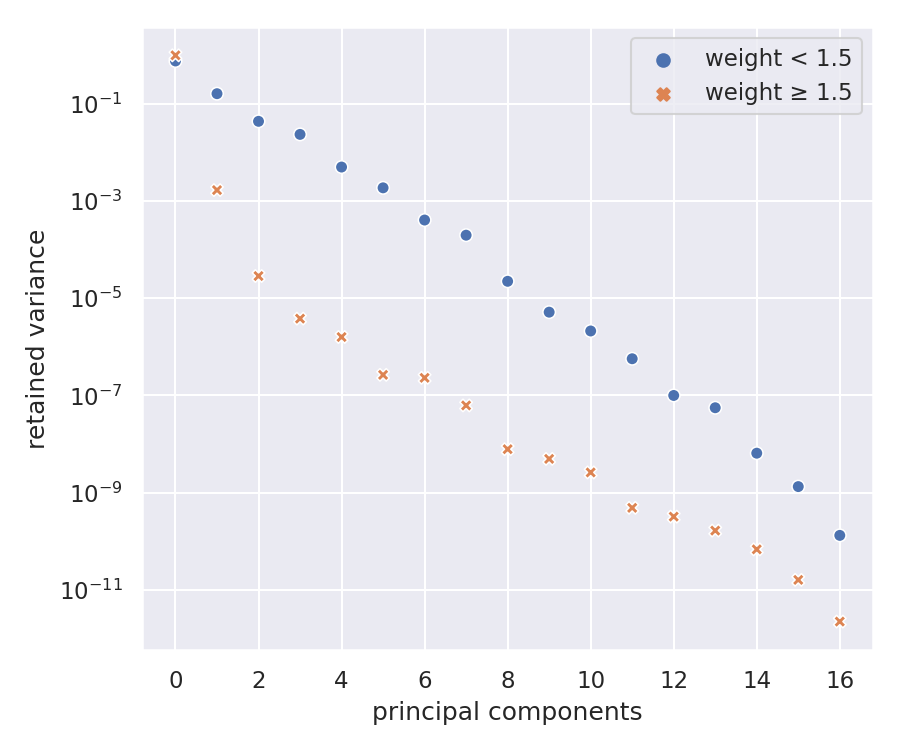

In [6]:
from IPython.display import Image
Image('./img/{}.png'.format(OUTPUT), width=480)

From this we see that the PCA can be performed on the first few components for the two datasets since most of the variance is already explained by the first component when `weight` $\ge 1.5$ or by the first two components when `weight` $<1.5$ (we drop the components which explain less than 10% of the variability):

In [7]:
svd = pd.read_csv('./data/{}.csv'.format(OUTPUT))

# show the components which retain more than 1.0e-6 of the variance
svd.loc[(svd['weight < 1.5'] > 1.0e-6) &
        (svd['weight ≥ 1.5'] > 1.0e-6)
       ]

,weight < 1.5,weight ≥ 1.5
0,0.763271,0.998286
1,0.161976,0.001679
2,0.043716,0.000029
3,0.023528,0.000004
4,0.005005,0.000002


Components for lower weights seem to be more balanced, even though the first two components account for more than 90% of the variance, while higher weights retain more variance in just one component:

In [8]:
svd_cumsum = svd.cumsum()
svd_cumsum.loc[(svd_cumsum['weight < 1.5'] <= 0.995) |
               (svd_cumsum['weight ≥ 1.5'] <= 0.995)
              ]

,weight < 1.5,weight ≥ 1.5
0,0.763271,0.998286
1,0.925247,0.999965
2,0.968963,0.999994
3,0.992491,0.999998


## Dimensionality Reduction

In order to be able to visualise the labels of the cluster, we compute the first two the principal components (PCA):

In [9]:
LOW         = './data/sft-trunc_eda_low_scaled.csv'
HIGH        = './data/sft-trunc_eda_high_scaled.csv'
COMP        = 2
OUTPUT_LOW  = 'pca_low'
OUTPUT_HIGH = 'pca_high'
RAND        = 123

!python3 ./scripts/pca.py --input {LOW} --comp {COMP} --output {OUTPUT_LOW} --rand {RAND}
!python3 ./scripts/pca.py --input {HIGH} --comp {COMP} --output {OUTPUT_HIGH} --rand {RAND}

PCA computed in 0.002 seconds
PCA computed in 0.001 seconds


## K-Means Clustering

In [10]:
LOW         = './data/sft-trunc_eda_low_scaled.csv'
HIGH        = './data/sft-trunc_eda_high_scaled.csv'
LABELS      = 3
PCA_LOW     = './data/pca_low.csv'
PCA_HIGH    = './data/pca_high.csv'
OUTPUT_LOW  = 'kmeans_low'
OUTPUT_HIGH = 'kmeans_high'
RAND        = 123

!python3 ./scripts/kmeans.py --input {LOW} --labels {LABELS} --pca {PCA_LOW} --output {OUTPUT_LOW} --rand {RAND}
!python3 ./scripts/kmeans.py --input {HIGH} --labels {LABELS} --pca {PCA_HIGH} --output {OUTPUT_HIGH} --rand {RAND}

KMeans clustering computed in 0.012 seconds
KMeans clustering computed in 0.011 seconds


We finally plot the cluster labels as functions of the components of the bidimensional PCA:

In [11]:
KMEANS_LOW  = './data/kmeans_low.csv'
KMEANS_HIGH = './data/kmeans_high.csv'
PCA_LOW     = './data/pca_low.csv'
PCA_HIGH    = './data/pca_high.csv'
EXP_LOW     = './data/sft-trunc_eda_low_exp.csv'
EXP_HIGH    = './data/sft-trunc_eda_high_exp.csv'
OUT_LOW     = 'kmeans_low'
OUT_HIGH    = 'kmeans_high'

!python3 ./scripts/kmeans_plot.py --exp {EXP_LOW} --kmeans {KMEANS_LOW} --pca {PCA_LOW} --output {OUT_LOW}
!python3 ./scripts/kmeans_plot.py --exp {EXP_HIGH} --kmeans {KMEANS_HIGH} --pca {PCA_HIGH} --output {OUT_HIGH}

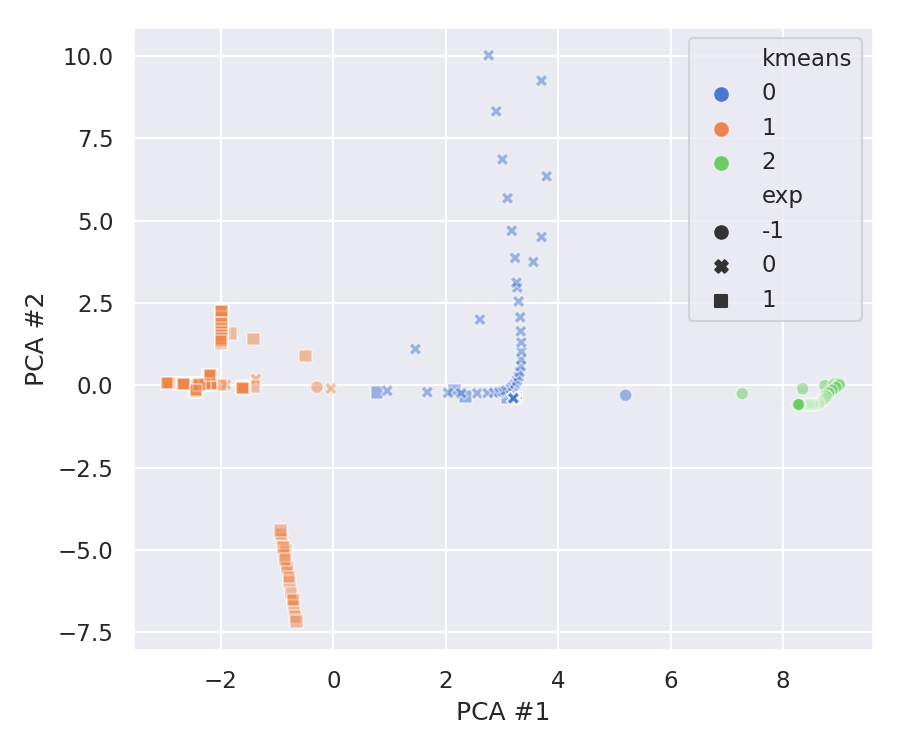

In [12]:
from IPython.display import Image
Image('./img/{}.png'.format(OUT_LOW), width=480)

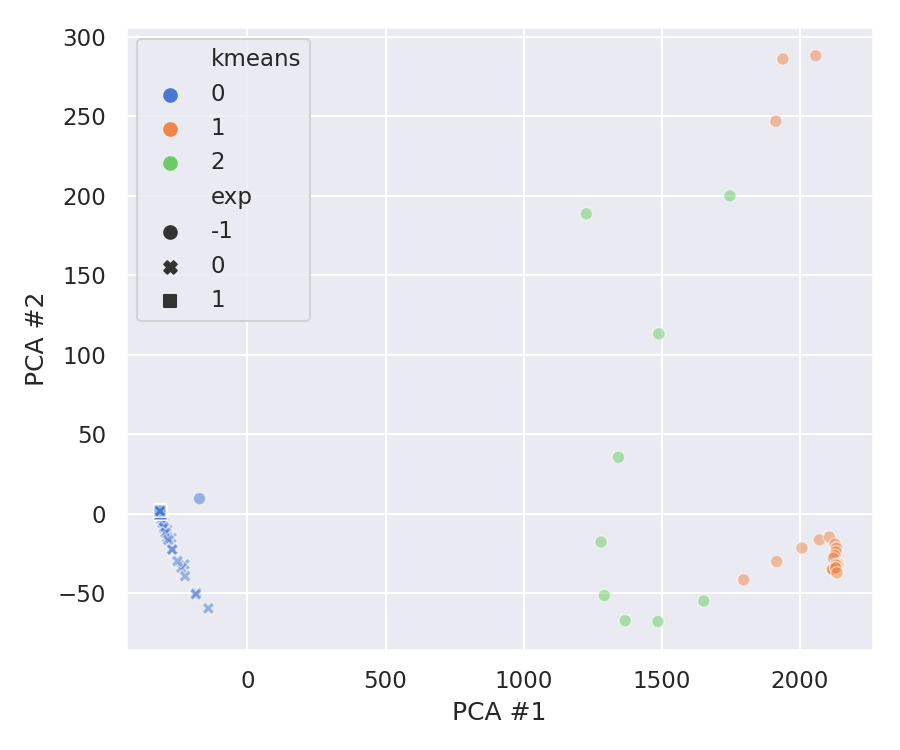

In [13]:
from IPython.display import Image
Image('./img/{}.png'.format(OUT_HIGH), width=480)

From the data it seems that when `weight` $<1.5$, the data present a good clustered structure which can well represent the distribution of the data. For example we can compute the mean of the labels of the clusters for each prediction label to see where their distribution is peaked:

In [14]:
df_low = pd.read_csv('./data/kmeans_low_plot.csv')
df_low.groupby(['exp']).agg({'kmeans': ['mean', 'var']})

kmeans          
         mean       var
exp                    
-1   1.891304  0.143478
 0   0.077778  0.072534
 1   0.978799  0.020826

In [15]:
df_high = pd.read_csv('./data/kmeans_high_plot.csv')
df_high.groupby(['exp']).agg({'kmeans': ['mean', 'var']})

kmeans          
         mean       var
exp                    
-1   1.130435  0.249275
 0   0.000000  0.000000
 1   0.000000  0.000000

It seems therefore that for `weight` $< 1.5$ it is possible to distinguish the extrapolated labels just by using unsupervised learning (the centroids are distinguishable and the labels can be safely separated), while when `weight` $\ge 1.5$ this is not possible.